In [2]:
# ----------------------------------------------------------
# Import required libraries
# ----------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

In [3]:
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette('husl')


In [4]:
# ----------------------------------------------------------
# Load the dataset
# ----------------------------------------------------------
# Note: Download dataset from Google Drive link and place it in data/raw/
df = pd.read_csv('../data/raw/mental_health_survey.csv')

print(f"Dataset shape: {df.shape}")
print("\nDataset info:")
df.info()


Dataset shape: (1259, 27)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options          

In [5]:
# ----------------------------------------------------------
# Display first few rows
# ----------------------------------------------------------
print("\nFirst 5 rows of the dataset:")
print(df.head())


First 5 rows of the dataset:
             Timestamp  Age  Gender         Country state self_employed  \
0  2014-08-27 11:29:31   37  Female   United States    IL           NaN   
1  2014-08-27 11:29:37   44       M   United States    IN           NaN   
2  2014-08-27 11:29:44   32    Male          Canada   NaN           NaN   
3  2014-08-27 11:29:46   31    Male  United Kingdom   NaN           NaN   
4  2014-08-27 11:30:22   31    Male   United States    TX           NaN   

  family_history treatment work_interfere    no_employees  ...  \
0             No       Yes          Often            6-25  ...   
1             No        No         Rarely  More than 1000  ...   
2             No        No         Rarely            6-25  ...   
3            Yes       Yes          Often          26-100  ...   
4             No        No          Never         100-500  ...   

                leave mental_health_consequence phys_health_consequence  \
0       Somewhat easy                        No

In [6]:
# ----------------------------------------------------------
# Check for missing values
# ----------------------------------------------------------
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
}).sort_values(by='Missing Percentage', ascending=False)

print("\nMissing Values Analysis:")
print(missing_df[missing_df['Missing Count'] > 0])


Missing Values Analysis:
                Missing Count  Missing Percentage
comments                 1095           86.973789
state                     515           40.905481
work_interfere            264           20.969023
self_employed              18            1.429706


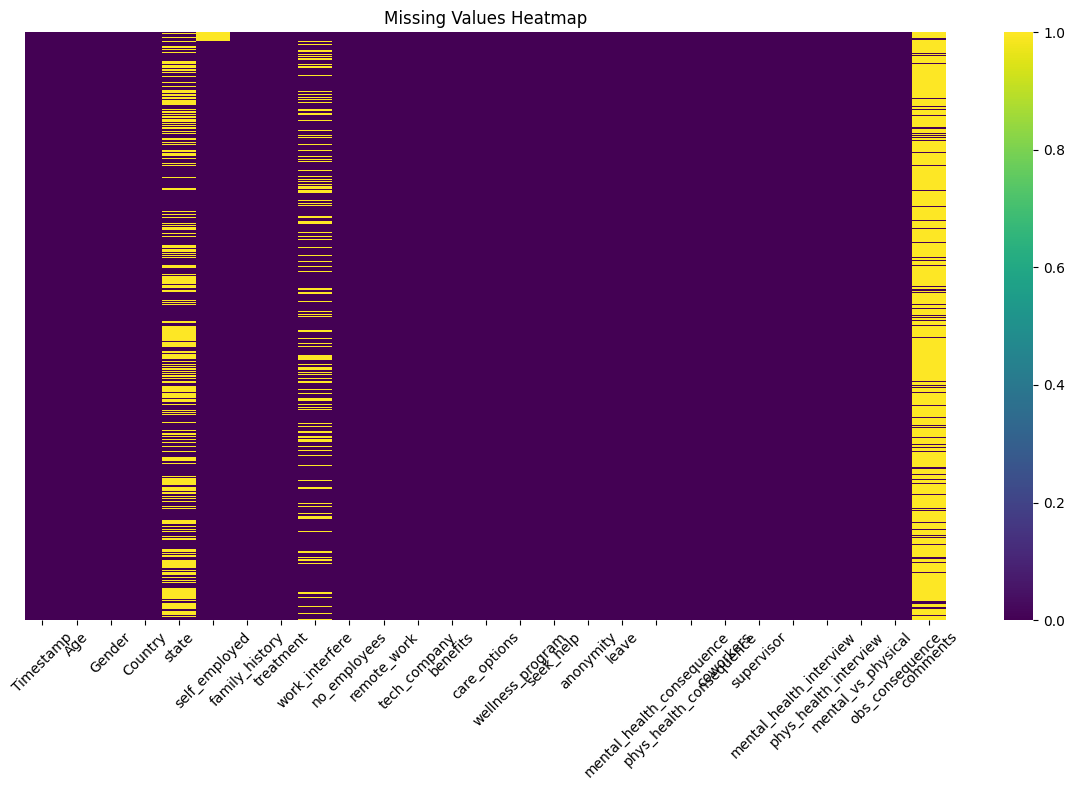

In [7]:
# ----------------------------------------------------------
# Visualize missing values
# ----------------------------------------------------------
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# ----------------------------------------------------------
# Clean Age column (remove outliers and invalid values)
# ----------------------------------------------------------
if 'Age' in df.columns:
    print("\nAge distribution before cleaning:")
    print(df['Age'].describe())

    # Remove invalid ages (less than 18 or greater than 100)
    df['Age'] = df['Age'].apply(lambda x: np.nan if x < 18 or x > 100 else x)

    # Fill missing ages with median
    df['Age'].fillna(df['Age'].median(), inplace=True)

    print("\nAge distribution after cleaning:")
    print(df['Age'].describe())


Age distribution before cleaning:
count    1.259000e+03
mean     7.942815e+07
std      2.818299e+09
min     -1.726000e+03
25%      2.700000e+01
50%      3.100000e+01
75%      3.600000e+01
max      1.000000e+11
Name: Age, dtype: float64

Age distribution after cleaning:
count    1259.000000
mean       32.069897
std         7.265565
min        18.000000
25%        27.000000
50%        31.000000
75%        36.000000
max        72.000000
Name: Age, dtype: float64


In [9]:
# ----------------------------------------------------------
# Clean Gender column
# ----------------------------------------------------------
if 'Gender' in df.columns:
    print("\nGender values before cleaning:")
    print(df['Gender'].value_counts())

    def standardize_gender(gender):
        if pd.isna(gender):
            return 'Other'
        gender = str(gender).lower().strip()

        if gender in ['male', 'm', 'man', 'male-ish', 'maile', 'cis male', 'male (cis)', 'cis man']:
            return 'Male'
        elif gender in ['female', 'f', 'woman', 'female-ish', 'femail', 'cis female', 'female (cis)', 'cis woman']:
            return 'Female'
        else:
            return 'Other'

    df['Gender'] = df['Gender'].apply(standardize_gender)

    print("\nGender values after cleaning:")
    print(df['Gender'].value_counts())



Gender values before cleaning:
Gender
Male                                              615
male                                              206
Female                                            121
M                                                 116
female                                             62
F                                                  38
m                                                  34
f                                                  15
Make                                                4
Male                                                3
Woman                                               3
Cis Male                                            2
Man                                                 2
Female (trans)                                      2
Female                                              2
Trans woman                                         1
msle                                                1
male leaning androgynous                   

In [10]:
# ----------------------------------------------------------
# Handle categorical missing values
# ----------------------------------------------------------
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    if col != 'treatment':  # Skip target variable
        if df[col].isnull().sum() > 0:
            mode_value = df[col].mode()
            if len(mode_value) > 0:
                df[col].fillna(mode_value[0], inplace=True)
            else:
                df[col].fillna('Unknown', inplace=True)
            print(f"Filled missing values in {col}")


Filled missing values in state
Filled missing values in self_employed
Filled missing values in work_interfere
Filled missing values in comments


In [11]:
# ----------------------------------------------------------
# Handle numerical missing values
# ----------------------------------------------------------
numerical_columns = df.select_dtypes(include=[np.number]).columns

for col in numerical_columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)
        print(f"Filled missing values in {col} with median")

In [12]:
# ----------------------------------------------------------
# Final check for missing values
# ----------------------------------------------------------
print("\nFinal missing values check:")
print(df.isnull().sum().sum())

if df.isnull().sum().sum() == 0:
    print("✅ All missing values handled successfully!")
else:
    print("⚠️ Some missing values still remain")
    print(df.isnull().sum()[df.isnull().sum() > 0])


Final missing values check:
0
✅ All missing values handled successfully!


In [13]:
# ----------------------------------------------------------
# Remove duplicate rows if any
# ----------------------------------------------------------
initial_rows = len(df)
df = df.drop_duplicates()
final_rows = len(df)

print(f"\nRemoved {initial_rows - final_rows} duplicate rows")
print(f"Final dataset shape: {df.shape}")


Removed 0 duplicate rows
Final dataset shape: (1259, 27)


In [14]:
# ----------------------------------------------------------
# Display final dataset info
# ----------------------------------------------------------
print("\nFinal cleaned dataset info:")
df.info()

print("\nTarget variable distribution:")
if 'treatment' in df.columns:
    print(df['treatment'].value_counts())
    print("\nTarget variable proportions:")
    print(df['treatment'].value_counts(normalize=True))


Final cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Timestamp                  1259 non-null   object 
 1   Age                        1259 non-null   float64
 2   Gender                     1259 non-null   object 
 3   Country                    1259 non-null   object 
 4   state                      1259 non-null   object 
 5   self_employed              1259 non-null   object 
 6   family_history             1259 non-null   object 
 7   treatment                  1259 non-null   object 
 8   work_interfere             1259 non-null   object 
 9   no_employees               1259 non-null   object 
 10  remote_work                1259 non-null   object 
 11  tech_company               1259 non-null   object 
 12  benefits                   1259 non-null   object 
 13  care_options       

In [15]:
# ----------------------------------------------------------
# Save cleaned dataset
# ----------------------------------------------------------
os.makedirs('../data/processed', exist_ok=True)
df.to_csv('../data/processed/cleaned_mental_health_data.csv', index=False)
print("✅ Cleaned dataset saved to '../data/processed/cleaned_mental_health_data.csv'")

✅ Cleaned dataset saved to '../data/processed/cleaned_mental_health_data.csv'
